- # Sistemas de Recomendacion - Plataforma Steam

https://github.com/cunimachine/Acamica-Proyecto3_Steam.git

# - Indice

### 1- Introduccion

### 2 - EDA - Analisis inicial de Datos.

### 2.1 - Sobre df_reviews

### 2.1 - Sobre df_games

### 3 - Preprocesamiento

### 3.1 - Sobre df_reviews

### 3.1.1 - Valores Nulos

### 3.1.2 - Outliers

### 3.1.2.1 - Sacando Outliers con el metodo de IQR

### 3.1.2.2 - Sacando Outliers con el metodo Manual

### 3.1.3 - Encoders

### 3.1.4 - Armado del Rating.

### 3.1.4.1 - En función de la distribución de las __Franjas de Tiempos__ (quintiles)

### 3.1.4.2 - En función de la distribución de las __Cantidades de los Datos__ (quintiles)

### 3.2 - Sobre df_games

### 3.2.1 - Valores Nulos

### 3.2.2 - Indexacion

### 3.2.3 - Eliminamos juegos repetidos

### 4 - Filtro Colaborativo

### 4.1 - Surprise

### 4.1.1 - Modelo Benchmark

### 4.1.2 - Modelo SVD

### 4.1.3 - Cross Validation

### 4.1.4 - GridSearch

### 5 - Conclusiones Generales

### 6 - Para seguir investigando
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


### 1- Introduccion

#### __Steam__ es un sistema de distribución de juegos multiplataforma en línea, con alrededor de 75 millones de usuarios activos, alrededor de 172 millones de cuentas en total, que aloja más de 30000 juegos.

#### Tenemos informacion de la plataforma de juegos Steam. Nuestro objetivo con los dataset steam_games.json.gz y steam_reviews.json.gz, es entrenar un sistema de recomendacion que nos permita recomendar juegos a los usuarios que por lo menos realizaron una reseña, con el menor RMSE posible.

### 2 - EDA - Analisis inicial de Datos.

#### Primero tenemos que descomprimir los archivos con la extencion .gz y luego transformarlos de .json a un dataset .csv (que permite manejar los datos con mas agilidad, con menos requerimientos de memoria y procesamiento).

In [1]:
#import gzip
#import pandas as pd

#def parse(path):
#    g = gzip.open(path, 'r')
#    for l in g:
#        yield eval(l)

#### - Con este codigo descomprimimos los 2 archivos.

### - steam_reviews.json.gz

In [2]:
#contador = 0
#data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
#n = 10
#for l in parse('steam_reviews.json.gz'):
#    if contador%n == 0:
#        data_reviews.append(l)
#    else:
#        pass
#    contador += 1


#### - Con este codigo solo tomamos una decima parte del dataset original para no colapsar la memoria RAM.

In [3]:
#data_reviews = pd.DataFrame(data_reviews)

In [4]:
#data_reviews.head(3)

#### - Creamos un archivo new_data_reviews.csv con el que vamos a trabajar.

In [5]:
#data_reviews.to_csv('new_data_reviews.csv')

### - steam_games.json.gz

In [6]:
#data_games = []
#for l in parse('steam_games.json.gz'):
#    data_games.append(l)
#data_games = pd.DataFrame(data_games)

In [7]:
#data_games.head(3)

#### - Creamos un archivo new_data_games.csv con el que vamos a trabajar.

In [8]:
#data_games.to_csv('new_data_games.csv')


### Ahora contamos con dos archivos csv de la plataforma de juegos Steam:

> #### __-new_data_games.csv:__ Tiene informacion sobre muchos de los juegos que ofrece la plataforma. Sus principales atributos son:
>> #### - "publisher" (editor) 
>> #### - "genres"(generos)
>> #### - "title"(nombre del juego)
>> #### - "release_date" (fecha en que se comenzo a comercializar)
>> #### - "tags" (etiquetas)
>> #### - "specs" (caracteristicas de juego)
>> #### - "id" (identificacion numerica y unica del juego)
>> #### - "developer" (desarrollador)
>> #### - "sentiment"(asigna al juego un __valor caracteristico__ en funcion de la valoracion que le pusieron los usuarios si es mas o menos valorado; tambien diferencia los casos en que no hay suficientes reseñas para evaluarlo)
>> #### - "metascore" ( valoracion numerica de 1 a 100, que tiene ese juego en la web www.metacritic.com)


> #### __-new_data_reviews.csv:__ Tiene informacion sobre las reseñas que realizaron los usuarios sobre los juegos que bajaron en dicha plataforma. Sus principales atributos son:
>> #### - "username" 
>> #### - "hours"(horas que ese usuario jugo a ese juego)
>> #### - "products" (es la cantidad de productos que el usuario compro en la plataforma)?
>> #### - "product_id" (identificacion numerica y unica del juego)
>> #### - "date" (fecha en que el usuario realizo la reseña)
>> #### - "text" (texto con observaciones del usuario)
>> #### - "found_funny" (las reseñas que realiza el usuario pueden ser marcadas como "funnys" por otros usuarios. Este indicador numerico es la cantidad de "calificaciones funny" que su reseña obtuvo)


#### Es importante señalar que las reseñas que el usuario realiza solo puede calificarlas con "dedito arriba" o "dedito abajo". Puede agregar un texto para mas detalle.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, FixedLocator
import seaborn as sns
sns.set()
import pandas as pd
import gc # garbage collector
from surprise import Dataset # convertimos nuestro Dataframe en Dataset
                             # es la estructura de datos que utiliza Surprise!, para almacenar la Matriz de Utilidad
                             # es la forma de almacenar datos con menos memoria, ya que la Matriz de Utilidad es muy grande     
from surprise import Reader # lector de Surprise
from surprise.model_selection import train_test_split
# quita calificacione de usuario de forma aleatoria a toda la matriz de utilidad, teniendo cuidado de no quitarle..
# ..todas las calificaciones a un usuario ni a un juego.
import os
import pandas as pd
from collections import defaultdict
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering 
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
import warnings


#### - Para trabajar cargamos los dos archivos .csv que recien creamos. Vamos a trabajar con dos df; df_reviews y df_games.

In [10]:
df_reviews = pd.read_csv('new_data_reviews.csv', dtype={'hours': np.float, 'product_id': np.int})
print(df_reviews.shape)
df_reviews.head(3)

(779307, 13)


,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN


In [11]:
df_games=pd.read_csv("new_data_games.csv")
print(df_games.shape)
df_games.head(3)

(32135, 17)


,Unnamed: 0,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN


### 2.1 - Sobre df_reviews

In [12]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779307 entries, 0 to 779306
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    779307 non-null  int64  
 1   username      779289 non-null  object 
 2   hours         776670 non-null  float64
 3   products      777741 non-null  float64
 4   product_id    779307 non-null  int32  
 5   page_order    779307 non-null  int64  
 6   date          779307 non-null  object 
 7   text          777468 non-null  object 
 8   early_access  779307 non-null  bool   
 9   page          779307 non-null  int64  
 10  user_id       317340 non-null  float64
 11  compensation  14588 non-null   object 
 12  found_funny   120164 non-null  float64
dtypes: bool(1), float64(4), int32(1), int64(3), object(4)
memory usage: 69.1+ MB


In [13]:
df_reviews.describe().round(1)

,Unnamed: 0,hours,products,product_id,page_order,page,user_id,found_funny
count,779307.0,776670.0,777741.0,779307.0,779307.0,779307.0,3.173400e+05,120164.0
mean,389653.0,111.8,237.0,251489.8,4.4,893.6,7.656120e+16,7.7
std,224966.7,390.1,486.0,149975.4,2.9,1928.3,1.007694e+08,72.5
min,0.0,0.0,1.0,10.0,0.0,1.0,7.656120e+16,1.0
25%,194826.5,4.0,45.0,203770.0,2.0,53.0,7.656120e+16,1.0
50%,389653.0,15.3,110.0,252490.0,4.0,238.0,7.656120e+16,1.0
75%,584479.5,59.6,246.0,346110.0,7.0,829.0,7.656120e+16,3.0
max,779306.0,28164.0,13540.0,773900.0,9.0,18371.0,7.656120e+16,6524.0


 - __"hours"__

>- La cantidad de horas jugadas de los usuarios que realizaron estas reseñas son en total 776670.
>- La desviacion standard es 4 veces la media.
>- __Crecimiento exponencial en el ultimo cuartil. En ese cuarto cuartil las hs comprendidas van de 60 a 28164.__

 - __"product_id"__

> Es un valor numerico pero que asigna referencia a un juego y solo a un juego en particular. Hace referencia al atributo "id" que tenemos en el df_games que se refiere solo a atributos del juego.

In [14]:
df_reviews.isnull().sum()

Unnamed: 0           0
username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

* *Variables con elementos faltantes:*  
    *1. `compensation` **98%** (764.719);*  
    *2. `found_funny` **86%** (659.143);*  
    *3. `user_id` 59% c/u (461.967);*  
    *4. `hours` 0,3% (2.637);*  
    *5. `text` 0,2% (1.839);*  
    *6. `product` 0,2% (1.566).*

- #### ¿Cuántos reseñas por usuario hay?

In [15]:
reseñas_por_usuario = df_reviews.username.value_counts()
print(reseñas_por_usuario)

123                        213
Alex                       190
Chris                      155
Nick                       143
Matt                       137
                          ... 
Fancyboy Ginswillington      1
Pengulon                     1
stin987                      1
Gorebane44                   1
chiewling.lee                1
Name: username, Length: 540338, dtype: int64


- #### Distribucion de las reseñas

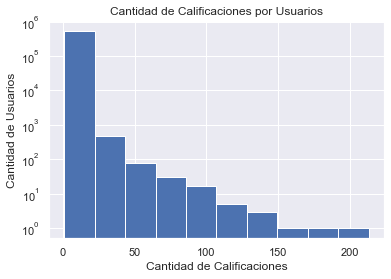

In [16]:
plt.hist(reseñas_por_usuario,log=True)

plt.xlabel('Cantidad de Calificaciones')
plt.ylabel('Cantidad de Usuarios')
plt.title('Cantidad de Calificaciones por Usuarios')
plt.show()

#### - Alrededor del 10% de los usuarios, son los que más calificaciones han realizado.

In [17]:
print("Hay ",len(df_reviews['username'].unique()), "usuarios unicos")

Hay  540339 usuarios unicos


In [18]:
print("Hay ",779307,"reseñas" )

Hay  779307 reseñas


In [19]:
print(" De los", len(df_games['id'].unique()),"juegos de los que tenemos info en el archivo df_games.csv; solo hay reseñas de ",
                     len(df_reviews['product_id'].unique()), " de esos juegos")

 De los 32133 juegos de los que tenemos info en el archivo df_games.csv; solo hay reseñas de  12665  de esos juegos


### 2.1 - Sobre df_games

In [20]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      32135 non-null  int64  
 1   publisher       24073 non-null  object 
 2   genres          28852 non-null  object 
 3   app_name        32133 non-null  object 
 4   title           30085 non-null  object 
 5   url             32135 non-null  object 
 6   release_date    30068 non-null  object 
 7   tags            31972 non-null  object 
 8   discount_price  225 non-null    float64
 9   reviews_url     32133 non-null  object 
 10  specs           31465 non-null  object 
 11  price           30758 non-null  object 
 12  early_access    32135 non-null  bool   
 13  id              32133 non-null  float64
 14  developer       28836 non-null  object 
 15  sentiment       24953 non-null  object 
 16  metascore       2607 non-null   float64
dtypes: bool(1), float64(3), int64(1

In [21]:
df_games.describe().round(1)

,Unnamed: 0,discount_price,id,metascore
count,32135.0,225.0,32133.0,2607.0
mean,16067.0,11.9,451757.4,72.3
std,9276.7,17.5,182714.0,10.8
min,0.0,0.5,10.0,20.0
25%,8033.5,1.4,329280.0,66.0
50%,16067.0,4.2,452060.0,74.0
75%,24100.5,22.7,593400.0,80.0
max,32134.0,140.0,2028850.0,96.0


In [22]:
df_games.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0            0
publisher          8062
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

* *Casi todas las Variables tienen elementos faltantes. Detallamos las principales:

    *1. `discount_price` **98%** (31.910);*  
    *2. `metascore` **98%** (29.528);*  
    *3. `publisher` 59% c/u (8.062);*  
    *4. `sentiment` 0,3% (7.182);*  
    *5. `developer` 0,2% (3.299);*  
    *6. `genres` 0,2% (3.283).*
   

#### - __El atributo "id"__ tiene un numero unico que representa al juego ("title") y se corresponde con el atributo "product_id" que esta en el df_reviews donde nos representa de que juego esta haciendo la reseña el usuario.

#### - __El atributo "sentiment"__: por cada juego, __simplifica en "forma categorica" el porcentaje de calificaciones positivas ("dedito arriba"), en relacion con las calificaciones negativas ("dedito abajo"), y el total de las reseñas o calificaciones sobre ese juego en particular.__ Tambien en el caso de este archivo nos da informacion sobre si las reseñas sobre ese juego en particular son muy escasas y por lo tanto no las caracteriza (ej: 8 users reviews, etc).

In [23]:
pd.unique(df_games['sentiment'])

array([nan, 'Mostly Positive', 'Mixed', '1 user reviews',
       '3 user reviews', '8 user reviews', 'Very Positive',
       'Overwhelmingly Positive', '6 user reviews', '5 user reviews',
       '2 user reviews', 'Very Negative', 'Positive', 'Mostly Negative',
       '9 user reviews', 'Negative', '4 user reviews', '7 user reviews',
       'Overwhelmingly Negative'], dtype=object)

In [24]:
print(df_games['sentiment'].value_counts())

Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     303
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Cantidad de juegos por tipo de caracterizacion del Atributo sentiment')

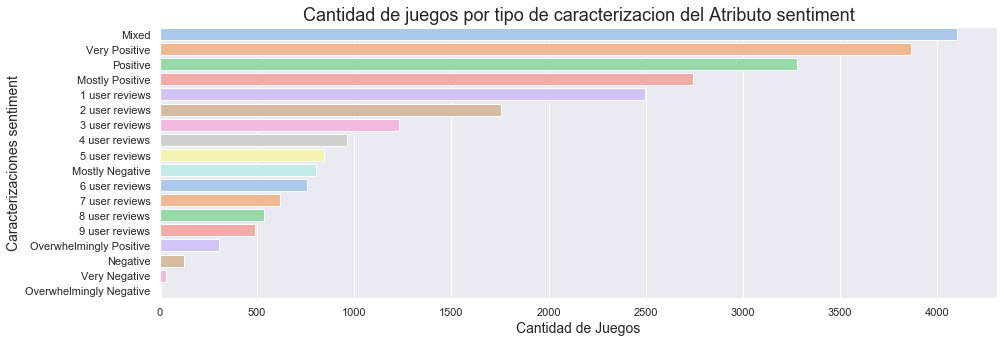

In [25]:
plt.subplots(figsize=(15, 5))

sns.countplot(data = df_games, y = 'sentiment', order = df_games['sentiment'].value_counts().index, palette='pastel')
plt.title('Número de Calificaciones por Tipo')

plt.xlabel('Cantidad de Juegos',size=14)
plt.ylabel('Caracterizaciones sentiment',size=14)
plt.title("Cantidad de juegos por tipo de caracterizacion del Atributo sentiment" ,size=18)

- #### Reseñas a partir de la calificaciones __metascore.__

In [26]:
print(df_games['metascore'].value_counts())

80.0    125
74.0    107
77.0    104
75.0    103
76.0    102
       ... 
42.0      1
33.0      1
34.0      1
20.0      1
29.0      1
Name: metascore, Length: 70, dtype: int64


In [27]:
print("En total tenemos " ,df_games['metascore'].value_counts().sum(),"juegos con calificacion de `metascore`")

En total tenemos  2607 juegos con calificacion de `metascore`


Text(0.5, 1.0, 'Número de Calificaciones por puntaje')

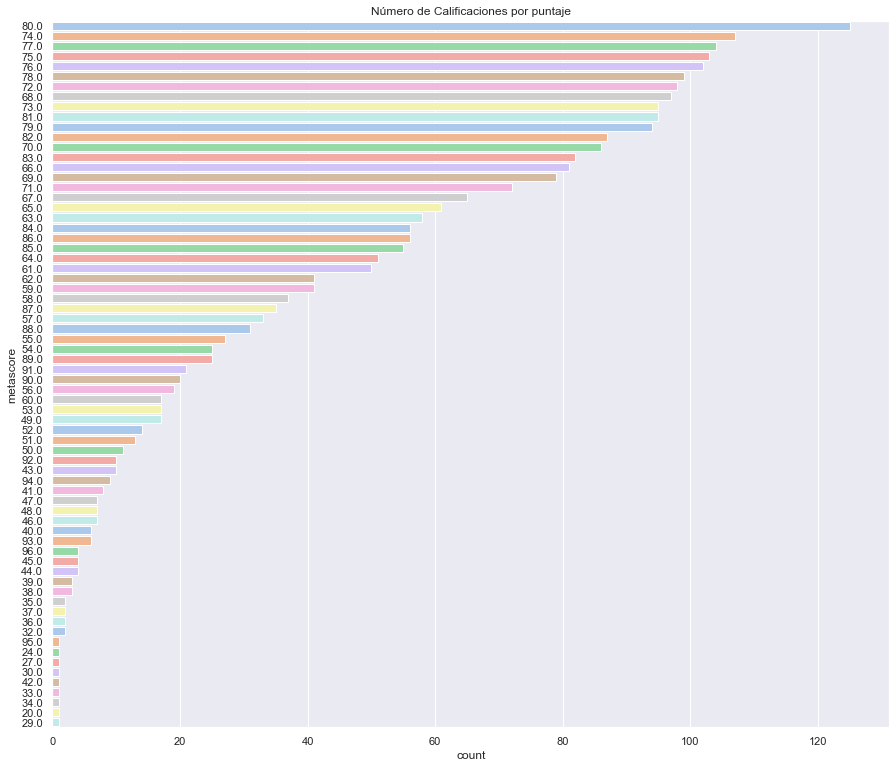

In [28]:
plt.figure(figsize = (15,13))
sns.countplot(data = df_games, y = df_games ["metascore"], order = df_games['metascore'].value_counts().index, palette='pastel')
plt.title('Número de Calificaciones por puntaje')

- #### Los juegos con mejores calificaciones son mas numerosos.

### 3 - Preprocesamiento
### 3.1 - Sobre df_reviews

#### * Los métodos de **filtrado colaborativo** construyen un modelo basado en el comportamiento pasado de los usuarios (artículos comprados anteriormente, películas vistas y calificadas, horas de juegos jugados etc.). Este modelo se utiliza luego para predecir elementos en los que el usuario puede estar interesado.

    - Ventajas: no necesitamos tener información acerca de los productos.
    - Desventajas: necesitamos construir la matríz de utilidad (que es muy dispersa) y llenarla es costosa en tiempo y dinero.
  
  
#### * Para implementarlo, necesitamos un dataset donde cada fila represente un `usuario`, un `juego` y la `calificación del usuario` a ese juego.

#### __CASO PARTICULAR STEAM__

>#### - No hay registros en el sitio web Steam, sobre las calificaciones de estos usuarios. En realidad, en la plataforma, los usuarios sólo pueden dar dos calificaciones que son "dedito arriba" (positivo) o "dedito abajo" (negativo).

>#### - Para obtener calificaciones continuas sobre la interacción entre los usuarios y los juegos, debemos suponer un mecanismo de interacción de calificación de los juegos por parte de los usuarios. 

>#### - Podemos asumir que pueden ser ajustadas por sus `tiempos de juego` (hours). El tiempo de juego es una información bastante persuasiva sobre los intereses de los usuarios. A mayor hs de juego, mayor seria la calificacion de ese usuario sobre ese juego.

>### - Por lo tanto, __aquí asumimos que el `tiempo de juego` (hours) es una parte muy importante de los intereses del usuario y la utilizaremos como clasificacion (rating).__

#### Seleccionamos aquellos **features que nos seran útiles** a la hora de realizar las predicciones.

In [29]:
df1_reviews = df_reviews[['username','hours','product_id']]
df1_reviews

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100
2,freakfantom,0.1,725280
3,The_Cpt_FROGGY,7.8,631920
4,the_maker988,8.2,35140
...,...,...,...
779302,Vidaar,783.5,252490
779303,Nikolai Belinski,55.1,252490
779304,RancorZealot,203.5,252490
779305,Jerry,139.8,252490


### 3.1.1 - Valores Nulos

In [30]:
df1_reviews.isnull().sum()

username        18
hours         2637
product_id       0
dtype: int64

#### - Los valores fatantes representan menos del 0,3% del total de instancias, por lo que se procede a eliminarlos, ya que no deberían generar grandes distorsiones en el dataset.

In [31]:
df2_reviews = df1_reviews.dropna()

In [32]:
df2_reviews.isnull().sum()

username      0
hours         0
product_id    0
dtype: int64

In [33]:
print(df2_reviews.shape)

(776652, 3)


### 3.1.2 - Outliers

#### - Un problema importante que tenemos con el atributo "hours" es que su distribucion es muy asimetrica para trabajarla, teniendo en cuenta que queremos convertirlo en un "ranking". Tiene muy pocas reseñas con muchas hs jugadas y la gran mayoria esta con muy pocas hs.

#### - El concepto de ranking implica en algun punto, que las distancias que hay entre "punto y punto" son iguales. Por ejemplo el puntaje 1 cabe 5 veces en el puntaje 5.

#### - Voy a construir dos df con distintos conceptos para luego poder utilizarlos con Surprise y ver cuales son sus comportamientos:
    1. new_df2_reviews: donde utilizo el metodo del IQR para sacarle los outliers.
    2. new_df3_reviews: donde extraigo x cantidades de outliers solo por arriba de la valla superior del 3er quartil.  


Text(0, 0.5, 'distribucion')

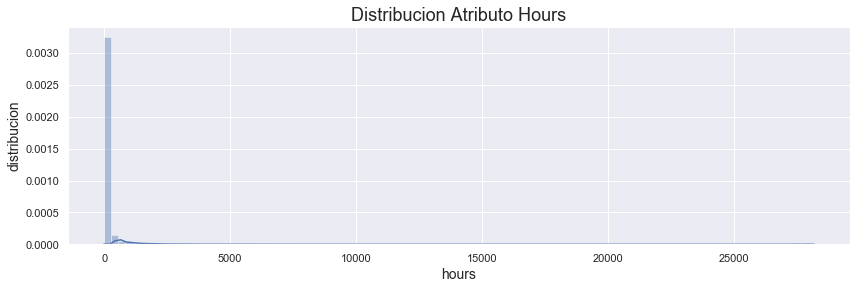

In [34]:
plt.subplots(figsize=(14,4))

plt.title("Distribucion Atributo Hours" ,size=18)
sns.distplot(df_reviews ["hours"],bins=100)
plt.xlabel('hours',size=14)
plt.ylabel('distribucion',size=14)


Text(0.5, 1.0, 'Distribucion Atributo hours')

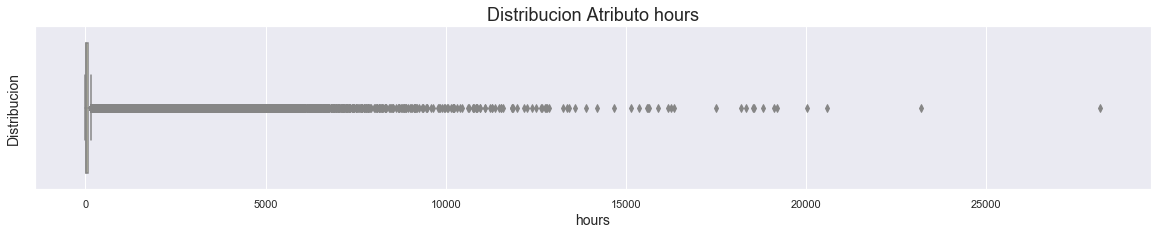

In [35]:
plt.subplots(figsize=(20, 3))

sns.boxplot(df2_reviews.hours,palette="Spectral",orient="h")
plt.xlabel('hours',size=14)
plt.ylabel('Distribucion',size=14)
plt.title("Distribucion Atributo hours" ,size=18)



### 3.1.2.1 - Sacando Outliers con el metodo de IQR:

In [36]:
Q1_hours=df2_reviews.hours.quantile(0.25)
Q3_hours=df2_reviews.hours.quantile(0.75)

IQR_hours=Q3_hours-Q1_hours
IQR_hours=Q3_hours-Q1_hours

rango_hours=IQR_hours*1.5

valla_superior_hours=Q3_hours+rango_hours
valla_inferior_hours=-(Q1_hours-rango_hours)

print("Rango de hours: ",valla_inferior_hours,valla_superior_hours)

Rango de hours:  79.4 143.0


In [37]:
new_df2_reviews=df2_reviews[(df2_reviews.hours>valla_inferior_hours)&(df2_reviews.hours<valla_superior_hours)]

In [38]:
a=len(new_df2_reviews.index)
b=len(df2_reviews.index)
c=b-a
e=c*100/b
print("La cantidad de reviews que perdemos son: ",c,"reviews; un ",e, " % de las reseñas." )

La cantidad de reviews que perdemos son:  724110 reviews; un  93.23480786761638  % de las reseñas.


In [39]:
new_df2_reviews.hours.describe().round(0)

count    52542.0
mean       107.0
std         18.0
min         80.0
25%         91.0
50%        105.0
75%        122.0
max        143.0
Name: hours, dtype: float64

Text(0.5, 1.0, 'Distribucion atributo hours')

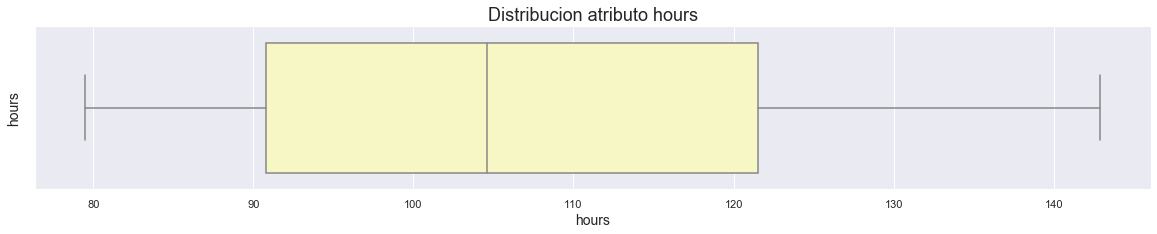

In [40]:
plt.subplots(figsize=(20, 3))

sns.boxplot(new_df2_reviews.hours,palette="Spectral",orient="h")
plt.xlabel('hours',size=14)
plt.ylabel('hours',size=14)
plt.title("Distribucion atributo hours" ,size=18)



### 3.1.2.2 - Sacando Outliers con el metodo manual:

#### - En este caso solo probare sacando outliers por arriba de la valla superior.

In [41]:
new_df3_reviews=df2_reviews[(df2_reviews.hours<4114)]

In [42]:
f=len(new_df3_reviews.index)
g=len(df2_reviews.index)
h=g-f
i=h*100/g
print("La cantidad de reviews que perdemos son: ",h,"reviews; un ",i, " % de las reseñas." )

La cantidad de reviews que perdemos son:  1147 reviews; un  0.14768519233839608  % de las reseñas.


Text(0.5, 1.0, 'Distribucion atributo hours')

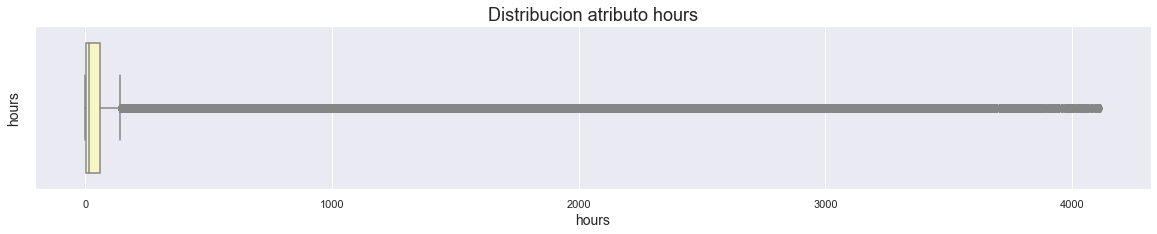

In [43]:
plt.subplots(figsize=(20, 3))

sns.boxplot(new_df3_reviews.hours,palette="Spectral",orient="h")
plt.xlabel('hours',size=14)
plt.ylabel('hours',size=14)
plt.title("Distribucion atributo hours" ,size=18)



### 3.1.3 - Encoders

#### - Cada nombre de usuario es **único**, lo cual se refleja en el feature `username` de nuestro dataset.
#### - Si bien Surpr!se puede trabajar con features bajo éstas condiciones, **se decide asignarle un Id a cada usuario único**, a fin de facilitar comparaciones a futuro.

In [44]:
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

le = LabelEncoder()
new_df3_reviews['username'] = le.fit_transform(new_df3_reviews['username'])
new_df2_reviews['username'] = le.fit_transform(new_df2_reviews['username'])

display(new_df3_reviews.head(3))
new_df2_reviews.head(3)

,username,hours,product_id
0,62286,0.1,725280
1,26768,13.2,328100
2,432912,0.1,725280


,username,hours,product_id
181,37779,99.9,399660
194,25809,125.0,350280
219,4375,121.9,344340


### 3.1.4 - Armado del Rating.

#### - Como ya comentamos el valor de clasificacion (rating) que utilizaremos sera el de tiempo jugado (atributo "hours").
#### - Se establecerán 2 posibilidades:
    1. Con 5 puntuaciones que **van del 1 a 5**, determinadas en función a la distribución de la Cantidad de Datos (quintiles).
    2. Con 5 puntuaciones que **van del 1 a 5**, determinadas en función a la distribución de los Tiempos (quintiles).


### 3.1.4.1 - En función de la distribución de las __Franjas de Tiempos__ (quintiles)

- #### A modo de demostración __(ya que no lo vamos a utilizar)__; se expone la concentración de datos resultante para un tipo de rating, si simplemente hubiéramos optado por tomar el valor máximo de horas, es decir 20573, y lo dividiéramos en 5 Bins.

In [45]:
demo2 = new_df2_reviews
demo3= new_df3_reviews

In [46]:
bins = [0, 4114.6, 8229.2, 12343.8, 16458.4, 20573]
labels =[1,2,3,4,5]

demo2['rating'] = pd.cut(demo2['hours'], bins,labels=labels)
demo3['rating'] = pd.cut(demo3['hours'], bins,labels=labels)

warnings.filterwarnings('ignore')

In [47]:
demo2['rating'].value_counts(normalize=True).round(7)
demo3['rating'].value_counts(normalize=True).round(7)


1    1.0
5    0.0
4    0.0
3    0.0
2    0.0
Name: rating, dtype: float64

<Figure size 432x288 with 0 Axes>

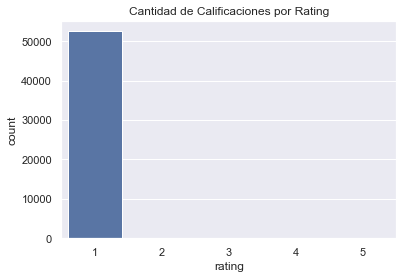

In [48]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (6,4))
plt.title('Cantidad de Calificaciones por Rating')
sns.countplot(data=demo2, x ='rating')

<Figure size 432x288 with 0 Axes>

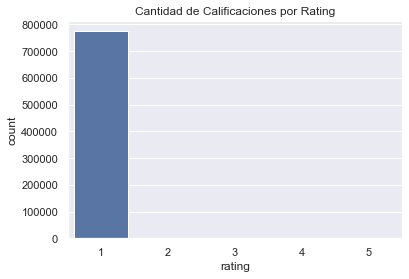

In [49]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (6,4))
plt.title('Cantidad de Calificaciones por Rating')
sns.countplot(data=demo3, x ='rating')

#### - Vemos que visualmente, todas las calificaciones quedan en **rating = 1**.
#### - En el caso del __new_df2_reviews__ esto efectivamente es asi porque la data extraida (outliers) fue entre  los valores que se encuentran emtre 79 y 143 horas. El rating 1 esta entre 0 y 4114.6
#### - En el caso del __new_df3_reviews__ la situacion es muy similar aunque tambien tenemos valores en los rating de 2 a 5. Son 1147 los valores que calificarian de 2 a 5. Seria un 0.14% de todo el dataset original.

### 3.1.4.2 - En función de la distribución de las __Cantidades de los Datos__ (quintiles)

- ### __Este es el  rating que vamos a utilizar.__

In [50]:
new_df3_reviews['rating'] = pd.qcut(new_df3_reviews.hours, 5, labels=['1', '2', '3', '4', '5'])
new_df2_reviews['rating'] = pd.qcut(new_df2_reviews.hours, 5, labels=['1', '2', '3', '4', '5'])

warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

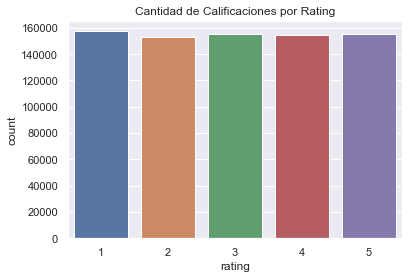

In [51]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (6,4))
plt.title('Cantidad de Calificaciones por Rating')
sns.countplot(data=new_df3_reviews, x ='rating')

In [52]:
pd.unique(new_df3_reviews['rating'])
#idem new_df2_reviews.

[1, 3, 2, 4, 5]
Categories (5, object): [1 < 2 < 3 < 4 < 5]

#### - Los valores resultan categóricos, ordenados de menor a mayor.
#### - Los pasamos a enteros, con el fin de poder seguir explorando sus datos.

In [53]:
new_df3_reviews['rating'] = new_df3_reviews['rating'].astype(int)
new_df2_reviews['rating'] = new_df2_reviews['rating'].astype(int)

warnings.filterwarnings('ignore')

#### - Eliminamos la columna de `hours`, dejando en su remplazo la confeccionada de `rating`.
#### - Reordenamos el orden de los atributos para que queden igual que nos lo solicita la Biblioteca Surprise.

In [54]:
final_reviews3 = new_df3_reviews[['username','product_id','rating']]
final_reviews2 = new_df2_reviews[['username','product_id','rating']]
display(final_reviews3)
final_reviews2

,username,product_id,rating
0,62286,725280,1
1,26768,328100,3
2,432912,725280,1
3,346580,631920,2
4,501883,35140,2
...,...,...,...
779301,299402,252490,5
779302,365460,252490,5
779303,241268,252490,4
779304,275192,252490,5


,username,product_id,rating
181,37779,399660,3
194,25809,350280,4
219,4375,344340,4
238,45711,335620,5
289,27933,344340,3
...,...,...,...
779283,15903,252490,1
779285,13230,252490,4
779289,44131,252490,2
779295,27989,252490,1


In [55]:
display(final_reviews3.dtypes)
final_reviews2.dtypes

username      int32
product_id    int32
rating        int32
dtype: object

username      int32
product_id    int32
rating        int32
dtype: object

#### - Tenemos int32 para todos los features, lo cual nos permitirá un mejor procesamiento de datos por menor utilizacion de memoria que si fueran Dtype int64.

#### - Creamos dos **Dataset de Reviews**, con Usuarios, Id de Productos y Rating. Nos quedaran como base por si queremos hacer analisis diversos en otro notebook.

In [56]:
final_reviews2.to_csv('final_reviews2.csv', index= False) # Guardamos el Dataset modificado en un nuevo archivo

In [57]:
final_reviews3.to_csv('final_reviews3.csv', index= False) # Guardamos el Dataset modificado en un nuevo archivo 

### 3.2 - Sobre df_games

#### - Seleccionamos aquellos **features que nos seran útiles** a la hora de realizar las predicciones.

#### - Nos serán útiles las columnas de `title`, para poder identificar el nombre de los juegos, y del `id` de los juegos, para realizar el cruce de datos con Data Reviews, donde los juegos estan identificados con el `id`.

In [58]:
df_titulo = pd.read_csv('new_data_games.csv', encoding = "ISO-8859-1", usecols = [4,13])
print(df_titulo.shape)
df_titulo.head()

(32135, 2)


,title,id
0,Lost Summoner Kitty,761140.0
1,Ironbound,643980.0
2,Real Pool 3D - Poolians,670290.0
3,å¼¹ç¸äºº2222,767400.0
4,NaN,773570.0


#### - Se **intercambian** las columnas, y se **renombra** la de `id`, a fin de que coincida con el dataset de Reviews donde se nombra "product_id".

In [59]:
df_titulo = df_titulo[['id','title']]
df_titulo.head()

,id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN


In [60]:
df_new = df_titulo.rename(columns={'id':'product_id'})
df_new

,product_id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN
...,...,...
32130,773640.0,Colony On Mars
32131,733530.0,LOGistICAL: South Africa
32132,610660.0,Russian Roads
32133,658870.0,EXIT 2 - Directions


### 3.2.1 - Valores Nulos

In [61]:
df_new.isnull().sum()

product_id       2
title         2050
dtype: int64

#### - Los valores fatantes representan el 6,4% del total de instancias.
#### - Se procede a eliminar todos ellos, ya que sin `product_id` no podemos cruzar los datos con el dataframe de Reviews, y sin `title` no podremos realizar las recomendaciones.

In [62]:
df_new_2 = df_new.dropna()

In [63]:
df_new_2

,product_id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
5,772540.0,Battle Royale Trainer
...,...,...
32129,745400.0,Kebab it Up!
32130,773640.0,Colony On Mars
32131,733530.0,LOGistICAL: South Africa
32132,610660.0,Russian Roads


In [64]:
df_new_2.isnull().sum()

product_id    0
title         0
dtype: int64

#### - El **Dataset Final de Games con el que vamos a trabajar**, representa un **93,6% del Dataset Original Descargado**.

### 3.2.2 - Indexacion

#### - Indexamos `product_id` a fin de poder realizar el cruce con el Dataset de Reviews.

In [65]:
df_new_2.dtypes

product_id    float64
title          object
dtype: object

- #### Precisamos que el tipo de dato sea entero para `product_id`, para poder realizar su indexación.

In [66]:
df_new_2[('product_id')] = df_new_2['product_id'].astype(int)

In [67]:
df_title = df_new_2.set_index('product_id', drop=True)
df_title

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
772540,Battle Royale Trainer
...,...
745400,Kebab it Up!
773640,Colony On Mars
733530,LOGistICAL: South Africa


In [68]:
df_title.dtypes

title    object
dtype: object

- ##### Luego, el tipo de dato de `pruduct_id` y `title` resultan ser **object**, siendo acorde para llevar a cabo nuestras recomendaciones a posteriori.

### 3.2.3 - Eliminamos juegos repetidos

#### - Se eliminan aquellos valores que se encuentran duplicados en `product_id`, ya que sólo puede haber 1 juego con el mismo Id.

In [69]:
print(df_title.loc[612880])

                                       title
product_id                                  
612880      Wolfenstein II: The New Colossus
612880      Wolfenstein II: The New Colossus


In [70]:
df_title = df_title[~df_title.index.duplicated(keep='first')]

In [71]:
df_title

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
772540,Battle Royale Trainer
...,...
745400,Kebab it Up!
773640,Colony On Mars
733530,LOGistICAL: South Africa


#### - Sólo había 1 juego duplicado.

#### - Obtuvimos el **Dataset de Games** final, con Usuarios y Id de Productos como Index, para poder realizar el cruce de datos con Reviews.

- #### Podemos obtener el nombre de un juego dado su `Id`.

In [72]:
product_id = 4574
print(df_new_2.loc[product_id])

product_id                                               406590
title         METAL GEAR SOLID V: THE PHANTOM PAIN - Sneakin...
Name: 4574, dtype: object


- #### ¿Cuáles son los juegos más populares? ¿Cuántas calificaciones tienen? ¿Y los juegos menos populares?

In [73]:
juegos_por_jugados = final_reviews2.product_id.value_counts()
juegos_por_jugados.index = df_title.loc[juegos_por_jugados.index].title
juegos_por_jugados

title
Borderlands 2                1453
Fallout 4                    1381
Team Fortress 2              1314
Rust                         1266
Grand Theft Auto V           1112
                             ... 
BioShockâ¢ 2 Remastered        1
Port Royale 2                   1
Winning Putt: Golf Online       1
Geneforge 5: Overthrow          1
HunieCam Studio                 1
Name: product_id, Length: 2424, dtype: int64

- #### El juego con mayor cantidad de reseñas es Team Fortress con 18372 calificaciones.
- #### Algunos de los juegos con 1 sola reseña son: The Perks of Being a Wallflower, CitiesCorp Concept - Build Everything on Your Own, Island Racer, Island Racer, The Frost y DP Animation Maker.*

### 4 - Filtro Colaborativo

- #### Lo siguiente ya fue detallado antes pero lo duplico por su importancia.

#### * Los métodos de **filtrado colaborativo** construyen un modelo basado en el comportamiento pasado de los usuarios (artículos comprados anteriormente, películas vistas y calificadas, horas de juegos jugados etc.). Este modelo se utiliza luego para predecir elementos en los que el usuario puede estar interesado.

    - Ventajas: no necesitamos tener información acerca de los productos.
    - Desventajas: necesitamos construir la matríz de utilidad (que es muy dispersa) y llenarla es costosa en tiempo y dinero.
  
  
#### * Para implementarlo, necesitamos un dataset donde cada fila represente un `usuario`, un `juego` y la `calificación del usuario` a ese juego.

#### __CASO PARTICULAR STEAM__

>#### - No hay registros en el sitio web Steam, sobre las calificaciones de estos usuarios. En realidad, en la plataforma, los usuarios sólo pueden dar dos calificaciones que son "dedito arriba" (positivo) o "dedito abajo" (negativo).

>#### - Para obtener calificaciones continuas sobre la interacción entre los usuarios y los juegos, debemos suponer un mecanismo de interacción de calificación de los juegos por parte de los usuarios. 

>#### - Podemos asumir que pueden ser ajustadas por sus `tiempos de juego` (hours). El tiempo de juego es una información bastante persuasiva sobre los intereses de los usuarios. A mayor hs de juego, mayor seria la calificacion de ese usuario sobre ese juego.

>### - Por lo tanto, __aquí asumimos que el `tiempo de juego` (hours) es una parte muy importante de los intereses del usuario y la utilizaremos como clasificacion (rating).__

### - Para realizar el sistema de recomendacion con el metodo de filtro colaborativo vamos a usar la libreria Surpise.

### 4.1 - Surprise

### 4.1.1 - Modelo Benchmark

#### - Voy a utilizar como Benchmark al modelo que utiliza como referencia la libreria Surprise donde aplica sus algoritmos a un dataset de peliculas.
#### - El rating utilizado es de 1 a 5. Igual que el que utilizaremos nosotros.
#### - El algoritmo utilizado es AlgoBase.
#### - __El RMSE obtenido es 1.5__

- #### En conclusiones al final del notebook intentare explicar porque en este caso el valor de RMSE de benchmark no representa una referencia de importancia y porque un RMSE mas bajo no significa necesariamente un buen recomendador; en este caso, de juegos.

### 4.1.2 - Modelo SVD++

- #### Hay muchos algoritmos en la libreria Surprise. Voy a utilizar SVD++ porque es el que presenta una mejor performance con el dataset de peliculas que utiliza Surprise como referencia.

### 4.1.2.1 - Con los hiperparametros por default.

### Importante: Recordar que vamos a trabajar con 2 df cuyas diferencias son el tratamiento que le hemos dado a los Outliers.

    1. Al df final_reviews2 le sacanmos los outliers con el metodo del Rango interquartil (IQR). Conservamos los datos entre 79 y  143 horas. La cantidad de reviews que perdimos son 724110, que representa un 93.2 % de las reseñas.
    
    2. Al df final_reviews3 le sacanmos los outliers con el metodo manual. Conservamos los datos por debajo de 4114 horas . La cantidad de reviews que perdimos son 1147, que representa un 0.14 % de las reseñas.


In [74]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(final_reviews2, reader)

#data = Dataset.load_from_df(final_reviews3, reader)

trainset, testset = train_test_split(data, test_size=.25)

algo = SVDpp() 

algo.fit(trainset)

predictions = algo.test(testset)

In [75]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.4114


1.411431803759685

- __Con SVD++ con hiperparametros por default.__

>- RMSE de final_reviews2: 1.41

>- RMSE de final_reviews3: 1.15

### 4.1.3 - Cross Validation

In [76]:

reader = Reader(rating_scale=(1, 5))

#data = Dataset.load_from_df(final_reviews2, reader)

data = Dataset.load_from_df(final_reviews3, reader)

algo = SVDpp()

cross_validate(algo, data, cv=5)

{'test_rmse': array([1.14683913, 1.14755854, 1.1433299 , 1.14396266, 1.14629482]),
 'test_mae': array([0.94432508, 0.94438685, 0.94083663, 0.94351715, 0.94465992]),
 'fit_time': (82.08528661727905,
  80.83353209495544,
  91.46592855453491,
  82.0186231136322,
  84.08793139457703),
 'test_time': (2.094111442565918,
  3.155864715576172,
  2.037423849105835,
  1.9899883270263672,
  1.9370307922363281)}

- __Con SVD++ con hiperparametros por default y CrossValidation de 5:__

>- RMSE de final_reviews2: 1.41

>- RMSE de final_reviews3: 1.14

### 4.1.4 - GridSearch

In [ ]:
from surprise.model_selection import GridSearchCV

reader = Reader(rating_scale=(1, 5))

#data = Dataset.load_from_df(final_reviews2, reader)

data = Dataset.load_from_df(final_reviews3, reader)

algo = SVDpp()

param_grid = {'n_factors': [5,50],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)

gs.fit(data)

In [ ]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

- __Con SVD++ con GridSearch:__

>- RMSE de final_reviews2: 1.40

>- RMSE de final_reviews3: 1.09

### 5 - Conclusiones Generales

#### Viendo los mejores RMSE que obtuvimos observamos que:

>#### - El df final_reviews2 que es al que le extrajimos __muchos outliers (93%)__, da un __peor RMSE (1.4).__
>#### - El df final_reviews3 que es al que le extrajimos __pocos outliers (0.14%)__, da un __mejor RMSE (1.09).__

### - Hagamos otro analisis pero con uno de los dos df creados como demo, donde la distribucion del rating fue solo optando por tomar el valor máximo de horas (20573), y lo dividiamos en 5 Bins. 

In [ ]:
bins = [0, 4114.6, 8229.2, 12343.8, 16458.4, 20573]
labels =[1,2,3,4,5]

demo2['rating'] = pd.cut(demo2['hours'], bins,labels=labels)

warnings.filterwarnings('ignore')

In [ ]:
demmo2=demo2.dropna()

In [ ]:
demo2['rating'] = demo2['rating'].astype(int)

warnings.filterwarnings('ignore')

In [ ]:
demo2= demo2[['username','product_id','rating']]

In [ ]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(demo2, reader)

trainset, testset = train_test_split(data, test_size=.25)

algo = SVDpp() 

algo.fit(trainset)

predictions = algo.test(testset)

In [ ]:
from surprise import accuracy

accuracy.rmse(predictions)

- ### Con esta modalidad de clasificacion de rating el RMSE que logramos es de 0.0130. Lo que podemos deducir es que el atributo "hours" y su distribucion muy asimetrica es determinante para este analisis y puede llegar a estar distorsionando mucho los resultados de RMSE.

- ### Es probable que un RMSE de 1.09 lo consideremos un buen resultado para este sistema de recomendacion; pero que en la practica no haga buenas recomendaciones. 



- ### Hay que "pulir" mucho mas este atributo como para poderlo utilizarlo con mas "confianza". Por ejemplo:



> ####    1. Hay dos preguntas que no tienen una respuesta facil y que marcan una incongruencia importante __en los jugadores que jugaron 0 hs__. Porque un usuario no jugo ni una hora un juego que compro, y porque escribio una reseña sobre un juego que no jugo? Aca seguramente tengamos que respondernos si el usuario lo compro por la plataforma Steam, pero decidio bajarlo a la pc y jugarlo por afuera de la plataforma impidiendo el conteo de las horas jugadas.

> ####   2. Las horas jugadas son contadas desde que el usuario compro el juego; pero logicamente no todos los usuarios compraron el juego en la misma fecha. Como los estamos considerando hasta ahora, si dos usuarios jugaron 100 hs un juego es lo mismo si lo compro hace un año que hace un mes. Tendriamos que normalizar esta distorsion de alguna manera.
    


### 6 - Para seguir investigando

#### - La utilizacion de procesamiento de lenguaje natural para asignar un puntaje a cada reseña en funcion de la critica escrita que realizo.

#### - Realizar un un analisis basada en contenidos con el dataset de games, y utilizando los atributos de "sentiment" y el puntaje de "metascort".